In [1]:
import numpy as np
import nibabel as nib
import glob
from tensorflow.keras.utils import to_categorical
import matplotlib.pyplot as plt
from tifffile import imsave
from IPython.display import clear_output
from sklearn.preprocessing import MinMaxScaler
import os
import splitfolders
import random
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, Conv3D, MaxPooling3D, concatenate, Conv3DTranspose, BatchNormalization, Dropout, Lambda
from tensorflow.keras.optimizers import Adam
from keras.metrics import MeanIoU
import keras
import segmentation_models_3D as sm
import pandas as pd

Segmentation Models: using `tf.keras` framework.


In [2]:
# import tensorflow as tf
tf.config.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU')]

In [3]:
scaler = MinMaxScaler()

#t1_list = sorted(glob.glob('BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1.nii'))
t2_list = sorted(glob.glob('brats_2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t2.nii'))
t1ce_list = sorted(glob.glob('brats_2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*t1ce.nii'))
flair_list = sorted(glob.glob('brats_2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*flair.nii'))
mask_list = sorted(glob.glob('brats_2020/BraTS2020_TrainingData/MICCAI_BraTS2020_TrainingData/*/*seg.nii'))

#Each volume generates 18 64x64x64x4 sub-volumes. 
#Total 369 volumes = 6642 sub volumes
count=0
for img in range(len(t2_list)):   #Using t1_list as all lists are of same size
    print("Now preparing image and masks number: ", img)
      
    temp_image_t2=nib.load(t2_list[img]).get_fdata()
    temp_image_t2=scaler.fit_transform(temp_image_t2.reshape(-1, temp_image_t2.shape[-1])).reshape(temp_image_t2.shape)
   
    temp_image_t1ce=nib.load(t1ce_list[img]).get_fdata()
    temp_image_t1ce=scaler.fit_transform(temp_image_t1ce.reshape(-1, temp_image_t1ce.shape[-1])).reshape(temp_image_t1ce.shape)
   
    temp_image_flair=nib.load(flair_list[img]).get_fdata()
    temp_image_flair=scaler.fit_transform(temp_image_flair.reshape(-1, temp_image_flair.shape[-1])).reshape(temp_image_flair.shape)
        
    temp_mask=nib.load(mask_list[img]).get_fdata()
    temp_mask=temp_mask.astype(np.uint8)
    temp_mask[temp_mask==4] = 3  #Reassign mask values 4 to 3
    #print(np.unique(temp_mask))
    
    temp_combined_images = np.stack([temp_image_flair, temp_image_t1ce, temp_image_t2], axis=3)
    
    #Crop to a size to be divisible by 64 so we can later extract 64x64x64 patches. 
    #cropping x, y, and z
    temp_combined_images=temp_combined_images[56:184, 56:184, 13:141]
    temp_mask = temp_mask[56:184, 56:184, 13:141]
    
    val, counts = np.unique(temp_mask, return_counts=True)
    
    # if (1 - (counts[0]/counts.sum())) > 0.01:  #At least 1% useful volume with labels that are not 0
        # print("Save Me")
    temp_mask= to_categorical(temp_mask, num_classes=4)
    np.save('BraTS2020_TrainingData/input_data_3channels/images/image_'+str(img)+'.npy', temp_combined_images)
    np.save('BraTS2020_TrainingData/input_data_3channels/masks/mask_'+str(img)+'.npy', temp_mask)
    count+=1
    # else:
    # print("I am useless")
    clear_output(wait=True)

  
print(count)


input_folder = 'BraTS2020_TrainingData/input_data_3channels/'
output_folder = 'BraTS2020_TrainingData/input_data_128/'
# Split with a ratio.
# To only split into training and validation set, set a tuple to `ratio`, i.e, `(.8, .2)`.
splitfolders.ratio(input_folder, output=output_folder, seed=42, ratio=(.75, .25), group_prefix=None) # default values

100


In [4]:
def load_img(img_dir, img_list):
    images=[]
    for i, image_name in enumerate(img_list):    
        if (image_name.split('.')[1] == 'npy'):
            
            image = np.load(img_dir+image_name)
                      
            images.append(image)
    images = np.array(images)
    
    return(images)




def imageLoader(img_dir, img_list, mask_dir, mask_list, batch_size):

    L = len(img_list)

    #keras needs the generator infinite, so we will use while true  
    while True:

        batch_start = 0
        batch_end = batch_size

        while batch_start < L:
            limit = min(batch_end, L)
                       
            X = load_img(img_dir, img_list[batch_start:limit])
            Y = load_img(mask_dir, mask_list[batch_start:limit])

            yield (X,Y) #a tuple with two numpy arrays with batch_size samples     

            batch_start += batch_size   
            batch_end += batch_size



In [5]:
kernel_initializer =  'he_uniform' #Try others if you want


################################################################
def simple_unet_model(IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS, num_classes):
#Build the model
    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_DEPTH, IMG_CHANNELS))
    #s = Lambda(lambda x: x / 255)(inputs)   #No need for this if we normalize our inputs beforehand
    s = inputs

    #Contraction path
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(s)
    c1 = Dropout(0.1)(c1)
    c1 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c1)
    p1 = MaxPooling3D((2, 2, 2))(c1)

    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c2)
    p2 = MaxPooling3D((2, 2, 2))(c2)

    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c3)
    p3 = MaxPooling3D((2, 2, 2))(c3)

    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p3)
    c4 = Dropout(0.2)(c4)
    c4 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c4)
    p4 = MaxPooling3D(pool_size=(2, 2, 2))(c4)

    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(p4)
    c5 = Dropout(0.3)(c5)
    c5 = Conv3D(256, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c5)

    #Expansive path
    u6 = Conv3DTranspose(128, (2, 2, 2), strides=(2, 2, 2), padding='same')(c5)
    u6 = concatenate([u6, c4])
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv3D(128, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c6)

    u7 = Conv3DTranspose(64, (2, 2, 2), strides=(2, 2, 2), padding='same')(c6)
    u7 = concatenate([u7, c3])
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u7)
    c7 = Dropout(0.2)(c7)
    c7 = Conv3D(64, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c7)

    u8 = Conv3DTranspose(32, (2, 2, 2), strides=(2, 2, 2), padding='same')(c7)
    u8 = concatenate([u8, c2])
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv3D(32, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c8)

    u9 = Conv3DTranspose(16, (2, 2, 2), strides=(2, 2, 2), padding='same')(c8)
    u9 = concatenate([u9, c1])
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(u9)
    c9 = Dropout(0.1)(c9)
    c9 = Conv3D(16, (3, 3, 3), activation='relu', kernel_initializer=kernel_initializer, padding='same')(c9)

    outputs = Conv3D(num_classes, (1, 1, 1), activation='softmax')(c9)

    model = Model(inputs=[inputs], outputs=[outputs])
    #compile model outside of this function to make it flexible.
    model.summary()
    # tf.keras.utils.plot_model(model, show_shapes=True)

    
    # img_file = './model_arch.png'

    # tf.keras.utils.plot_model(model, to_file=img_file, show_shapes=True, show_layer_names=True)
    return model

#Test if everything is working ok.
model = simple_unet_model(128, 128, 128, 3, 4)
print(model.input_shape)
print(model.output_shape)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d (Conv3D)                (None, 128, 128, 12  1312        ['input_1[0][0]']                
                                8, 16)                                                            
                                                                                                  
 dropout (Dropout)              (None, 128, 128, 12  0           ['conv3d[0][0]']                 
                                8, 16)                                                        

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                28, 3)]                                                           
                                                                                                  
 conv3d_19 (Conv3D)             (None, 128, 128, 12  1312        ['input_2[0][0]']                
                                8, 16)                                                            
                                                

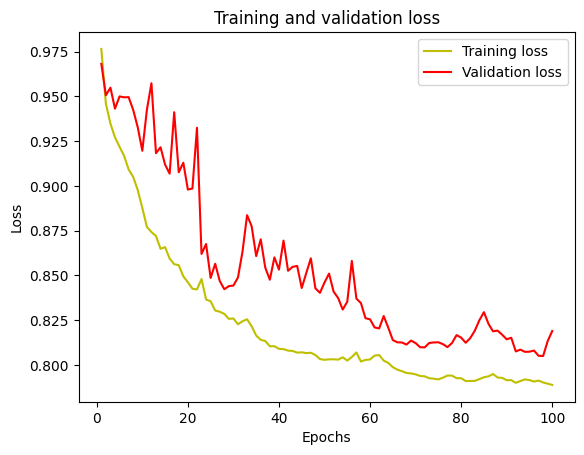

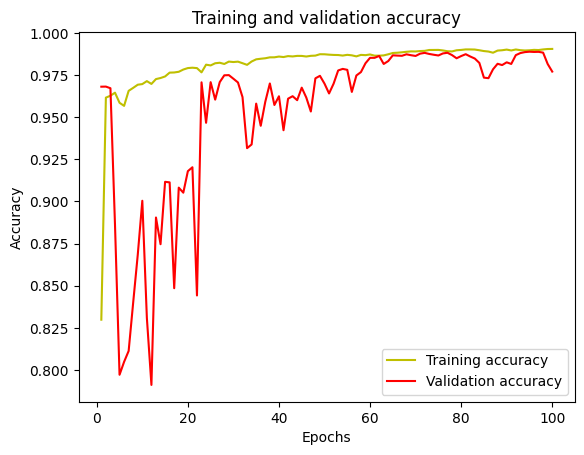

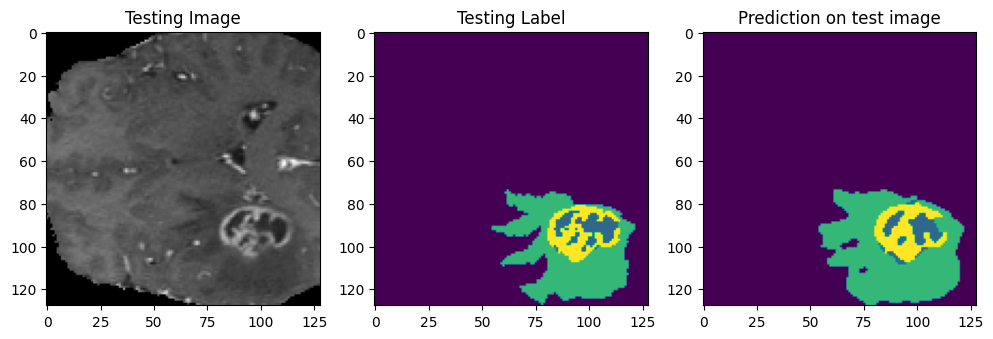

In [6]:

train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

img_list = os.listdir(train_img_dir)
msk_list = os.listdir(train_mask_dir)

num_images = len(os.listdir(train_img_dir))

img_num = random.randint(0,num_images-1)
test_img = np.load(train_img_dir+img_list[img_num])
test_mask = np.load(train_mask_dir+msk_list[img_num])
test_mask = np.argmax(test_mask, axis=3)


columns = ['0','1', '2', '3']
df = pd.DataFrame(columns=columns)
train_mask_list = sorted(glob.glob('BraTS2020_TrainingData/input_data_128/train/masks/*.npy'))
for img in range(len(train_mask_list)):
    print(img)
    temp_image=np.load(train_mask_list[img])
    temp_image = np.argmax(temp_image, axis=3)
    val, counts = np.unique(temp_image, return_counts=True)
    zipped = zip(columns, counts)
    conts_dict = dict(zipped)
    
    df = df._append(conts_dict, ignore_index=True)

label_0 = df['0'].sum()
label_1 = df['1'].sum()
label_2 = df['1'].sum()
label_3 = df['3'].sum()
total_labels = label_0 + label_1 + label_2 + label_3
n_classes = 4
#Class weights claculation: n_samples / (n_classes * n_samples_for_class)
wt0 = round((total_labels/(n_classes*label_0)), 2) #round to 2 decimals
wt1 = round((total_labels/(n_classes*label_1)), 2)
wt2 = round((total_labels/(n_classes*label_2)), 2)
wt3 = round((total_labels/(n_classes*label_3)), 2)

#Weights are: 0.26, 22.53, 22.53, 26.21
#wt0, wt1, wt2, wt3 = 0.26, 22.53, 22.53, 26.21
#These weihts can be used for Dice loss 

##############################################################
#Define the image generators for training and validation

train_img_dir = "BraTS2020_TrainingData/input_data_128/train/images/"
train_mask_dir = "BraTS2020_TrainingData/input_data_128/train/masks/"

val_img_dir = "BraTS2020_TrainingData/input_data_128/val/images/"
val_mask_dir = "BraTS2020_TrainingData/input_data_128/val/masks/"

train_img_list=os.listdir(train_img_dir)
train_mask_list = os.listdir(train_mask_dir)

val_img_list=os.listdir(val_img_dir)
val_mask_list = os.listdir(val_mask_dir)
##################################

########################################################################
batch_size = 2

train_img_datagen = imageLoader(train_img_dir, train_img_list, 
                                train_mask_dir, train_mask_list, batch_size)

val_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
img, msk = train_img_datagen.__next__()

img_num = random.randint(0,img.shape[0]-1)
test_img=img[img_num]
test_mask=msk[img_num]
test_mask=np.argmax(test_mask, axis=3)

n_slice=random.randint(0, test_mask.shape[2])
# plt.figure(figsize=(12, 8))

# plt.subplot(221)
# plt.imshow(test_img[:,:,n_slice, 0], cmap='gray')
# plt.title('Image flair')
# plt.subplot(222)
# plt.imshow(test_img[:,:,n_slice, 1], cmap='gray')
# plt.title('Image t1ce')
# plt.subplot(223)
# plt.imshow(test_img[:,:,n_slice, 2], cmap='gray')
# plt.title('Image t2')
# plt.subplot(224)
# plt.imshow(test_mask[:,:,n_slice])
# plt.title('Mask')
# plt.show()


###########################################################################
#Define loss, metrics and optimizer to be used for training
wt0, wt1, wt2, wt3 = 0.25,0.25,0.25,0.25

dice_loss = sm.losses.DiceLoss(class_weights=np.array([wt0, wt1, wt2, wt3])) 
focal_loss = sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)

metrics = ['accuracy', sm.metrics.IOUScore(threshold=0.5)]

LR = 0.0001
optim = tf.keras.optimizers.Adam(LR)
#######################################################################
#Fit the model 

steps_per_epoch = len(train_img_list)//batch_size
val_steps_per_epoch = len(val_img_list)//batch_size


model = simple_unet_model(IMG_HEIGHT=128, 
                          IMG_WIDTH=128, 
                          IMG_DEPTH=128, 
                          IMG_CHANNELS=3, 
                          num_classes=4)

model.compile(optimizer = optim, loss=total_loss, metrics=metrics)
print(model.summary())

print(model.input_shape)
print(model.output_shape)

history=model.fit(train_img_datagen,
          steps_per_epoch=steps_per_epoch,
          epochs=100,
          verbose=1,
          validation_data=val_img_datagen,
          validation_steps=val_steps_per_epoch,
          )

model.save('brats_3d.hdf5')
##################################################################


#plot the training and validation IoU and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

plt.plot(epochs, acc, 'y', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()
#################################################
# from keras.models import load_model

# #Load model for prediction or continue training

# #For continuing training....
# #The following gives an error: Unknown loss function: dice_loss_plus_1focal_loss
# #This is because the model does not save loss function and metrics. So to compile and 
# #continue training we need to provide these as custom_objects.
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5')

# #So let us add the loss as custom object... but the following throws another error...
# #Unknown metric function: iou_score
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss})

# #Now, let us add the iou_score function we used during our initial training
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
#                       custom_objects={'dice_loss_plus_1focal_loss': total_loss,
#                                       'iou_score':sm.metrics.IOUScore(threshold=0.5)})

# #Now all set to continue the training process. 
# history2=my_model.fit(train_img_datagen,
#           steps_per_epoch=steps_per_epoch,
#           epochs=1,
#           verbose=1,
#           validation_data=val_img_datagen,
#           validation_steps=val_steps_per_epoch,
#           )
# #################################################

# #For predictions you do not need to compile the model, so ...
# my_model = load_model('saved_models/brats_3d_100epochs_simple_unet_weighted_dice.hdf5', 
#                       compile=False)


# #Verify IoU on a batch of images from the test dataset
# #Using built in keras function for IoU
# #Only works on TF > 2.0
from keras.metrics import MeanIoU

batch_size=8 #Check IoU for a batch of images
test_img_datagen = imageLoader(val_img_dir, val_img_list, 
                                val_mask_dir, val_mask_list, batch_size)

#Verify generator.... In python 3 next() is renamed as __next__()
test_image_batch, test_mask_batch = test_img_datagen.__next__()

test_mask_batch_argmax = np.argmax(test_mask_batch, axis=4)
test_pred_batch = my_model.predict(test_image_batch)
test_pred_batch_argmax = np.argmax(test_pred_batch, axis=4)

n_classes = 4
IOU_keras = MeanIoU(num_classes=n_classes)  
IOU_keras.update_state(test_pred_batch_argmax, test_mask_batch_argmax)
print("Mean IoU =", IOU_keras.result().numpy())

#############################################
#Predict on a few test images, one at a time
#Try images: 
img_num = 82

test_img = np.load("BraTS2020_TrainingData/input_data_128/val/images/image_"+str(img_num)+".npy")

test_mask = np.load("BraTS2020_TrainingData/input_data_128/val/masks/mask_"+str(img_num)+".npy")
test_mask_argmax=np.argmax(test_mask, axis=3)

test_img_input = np.expand_dims(test_img, axis=0)
test_prediction = model.predict(test_img_input)
test_prediction_argmax=np.argmax(test_prediction, axis=4)[0,:,:,:]


# print(test_prediction_argmax.shape)
# print(test_mask_argmax.shape)
# print(np.unique(test_prediction_argmax))


#Plot individual slices from test predictions for verification

#n_slice=random.randint(0, test_prediction_argmax.shape[2])
n_slice = 55
plt.figure(figsize=(12, 8))
plt.subplot(231)
plt.title('Testing Image')
plt.imshow(test_img[:,:,n_slice,1], cmap='gray')
plt.subplot(232)
plt.title('Testing Label')
plt.imshow(test_mask_argmax[:,:,n_slice])
plt.subplot(233)
plt.title('Prediction on test image')
plt.imshow(test_prediction_argmax[:,:, n_slice])
plt.show()

############################################################

